In [15]:
import os
import sys
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import seaborn
import scipy.stats as stats
import networkx as nx
import geopandas as gp
import random
from mpl_toolkits.axes_grid1 import make_axes_locatable


# NOTE: I am ignoring the max iteration warnings for nmf
warnings.filterwarnings("ignore")

cwd = os.getcwd()
#par = os.path.join(cwd, os.pardir)
par = os.path.dirname(cwd)
sys.path.append(par)

# I made some modules to make importing easier and to have a nice class
# that does all the matrix operations
import matrix_operation
import nmf_clustering
#import state_adj
import graph_operation
import links_and_initiators

In [16]:
# Just to reload the modules I imported above so I dont need to restart the kernel after making changes
import importlib
importlib.reload(matrix_operation)
importlib.reload(nmf_clustering)
#importlib.reload(state_adj)
importlib.reload(graph_operation)
importlib.reload(links_and_initiators)

from matrix_operation import mat_opr
from nmf_clustering import nmf_cluster
#from state_adj import make_graph
from graph_operation import *
from links_and_initiators import *

### Testing the model

In [3]:
# pi(G,N | M) = 1/Z * P(M | G, N) * P(G) * P(N)

# P(M(i,u) | G,N) = 1 - abs(M(i,u) - N(i,u)) * Product over all v != u ( 1 - abs(M(i,u) - N(i,v)) * b(u,v,G))

In [17]:
M_test = [[0.93, 0.95, 0.97, 0.12, 0.05, 0.09],
           [0.62, 0.73, 0.61, 0.84, 0.76, 0.79],
           [0.01, 0.06, 0.11, 0.99, 0.95, 0.93]]
M_test = pd.DataFrame(M_test).T
M_test.columns = ['state 0', 'state 1', 'state 2']

In [18]:
M_test3 = [[0.36, 0.28, 0.51, 0.11, 0.05, 0.14],
           [0.20, 0.25, 0.43, 0.23, 0.21, 0.34],
           [0.05, 0.10, 0.01, 0.32, 0.37, 0.44]]
M_test3 = pd.DataFrame(M_test3).T
M_test3.columns = ['state 0', 'state 1', 'state 2']

In [19]:
M_test3

,state 0,state 1,state 2
0,0.36,0.20,0.05
1,0.28,0.25,0.10
2,0.51,0.43,0.01
3,0.11,0.23,0.32
4,0.05,0.21,0.37
5,0.14,0.34,0.44


In [20]:
test_links = applied_links_initiators(M_test3, 2000,10, 0.9, 2, 9)

In [21]:
g_test, n_test = test_links.find()

After burn in: 
         state 0  state 1  state 2
state 0        0        1        0
state 1        0        0        0
state 2        0        0        0
   state 0  state 1  state 2
0      1.0      0.0      0.0
1      1.0      0.0      0.0
2      1.0      0.0      0.0
3      0.0      0.0      1.0
4      0.0      0.0      1.0
5      0.0      1.0      1.0


In [22]:
g_test[-1]

,state 0,state 1,state 2
state 0,0.0,1.0,0.0
state 1,0.0,0.0,0.0
state 2,0.0,0.0,0.0


In [23]:
n_test[-1]

,state 0,state 1,state 2
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
5,0.0,1.0,1.0


### Import data

In [3]:
state_dset = pd.read_csv(os.path.join(par, 'collected_data/state_dataset.csv'), index_col = 0)
state_dset = mat_opr(state_dset)

In [4]:
population = pd.read_csv(os.path.join(par, 'collected_data/state_census_estimate.csv'), index_col = 'NAME')

In [5]:
state_map = gp.read_file('US_States_geojson.json')
state_caps = pd.read_csv(os.path.join(par, "collected_data/us_state_capitals.csv"))

In [6]:
state_adjy = pd.read_csv(os.path.join(par, 'collected_data/state_adjacency.csv'), index_col = 0)

### Iso + Normalize

In [7]:
state_iso = state_dset.known_iso()

In [8]:
pop_dict = {}
for col in state_iso.dataframe.columns:
    pop_dict[col] = population.loc[col,'POP']
    
state_norm = state_iso.population_normalizer(pop_dict)

### NMF

In [76]:
nmfed = nmf_cluster(state_norm.dataframe, 4, clusters=None, cluster_method='kmeans', num_outliers=None)

In [77]:
nmfed.y_table

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
basis 0,0.390952,0.333858,0.438719,0.417029,0.362228,0.301305,0.304096,0.350001,0.202072,0.344478,...,0.499470,0.454517,0.357412,0.460923,0.106427,0.262463,0.175897,0.312136,0.418367,0.382587
basis 1,0.091176,0.101424,0.053160,0.092845,0.035130,0.087487,0.056642,0.056517,0.059874,0.068177,...,0.237301,0.103088,0.067342,0.125238,0.000000,0.034454,0.041332,0.035525,0.175199,0.135888
basis 2,0.128161,0.009032,0.139553,0.105538,0.088714,0.016985,0.040311,0.066942,0.079530,0.143705,...,0.044300,0.103854,0.110342,0.067179,0.000000,0.065438,0.038560,0.015731,0.046976,0.000000
basis 3,0.046138,0.022577,0.053416,0.017407,0.013941,0.093996,0.214552,0.175019,0.211711,0.084661,...,0.074763,0.034481,0.039372,0.037553,0.068592,0.088356,0.060780,0.014996,0.028613,0.010696


### Links and initiators

In [78]:
M = nmfed.y_table
M.columns = state_norm.dataframe.columns

In [79]:
links = applied_links_initiators(M, 5000,10, 0.9, 2, 9)

In [80]:
g,n = links.find()

After burn in: 
                      Alabama  Alaska  Arizona  Arkansas  California  \
Alabama                     0       0        0         0           1   
Alaska                      0       0        0         0           0   
Arizona                     0       0        0         0           0   
Arkansas                    0       0        0         0           0   
California                  0       0        0         0           0   
Colorado                    0       0        0         0           0   
Connecticut                 0       0        0         0           0   
Delaware                    0       0        0         0           0   
District of Columbia        0       0        0         0           0   
Florida                     0       0        0         0           0   
Georgia                     0       0        0         0           0   
Hawaii                      0       0        0         0           0   
Idaho                       0       0        0  

In [81]:
gs = g[-1]
gs.columns = state_norm.dataframe.columns
gs.index = state_norm.dataframe.columns

In [82]:
ns = n[-1]
ns.columns = state_norm.dataframe.columns

In [83]:
ns

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
basis 0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
basis 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
basis 2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
basis 3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## N

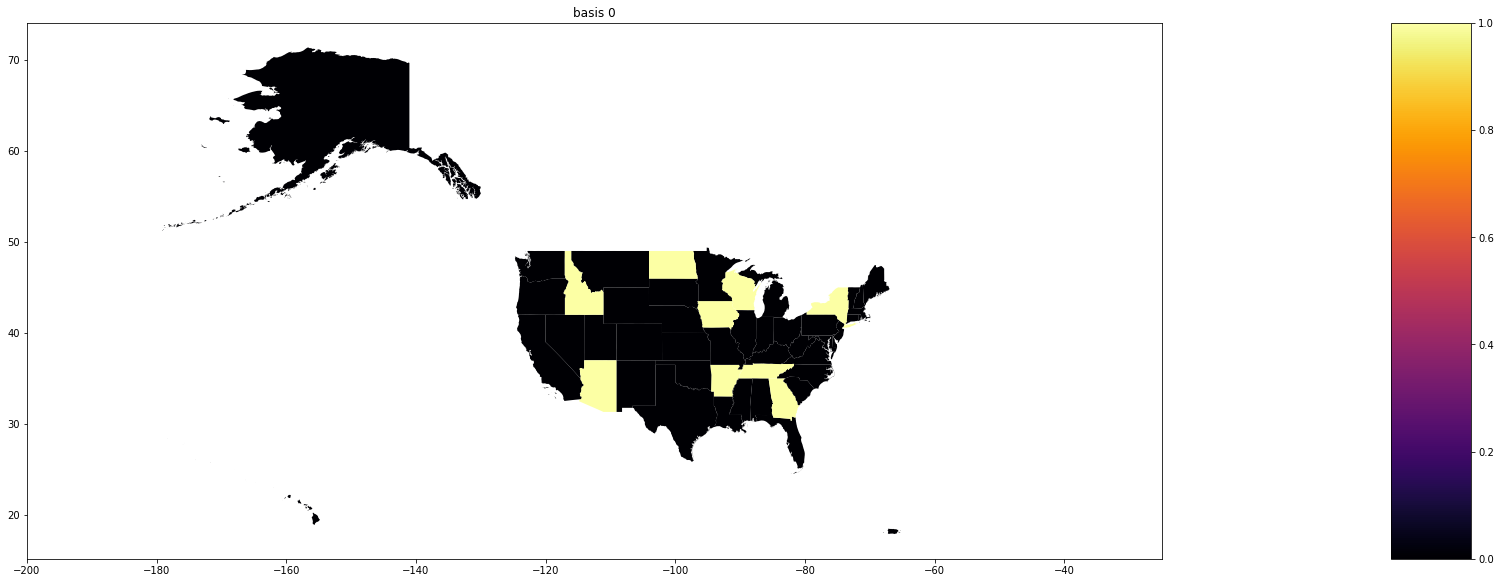

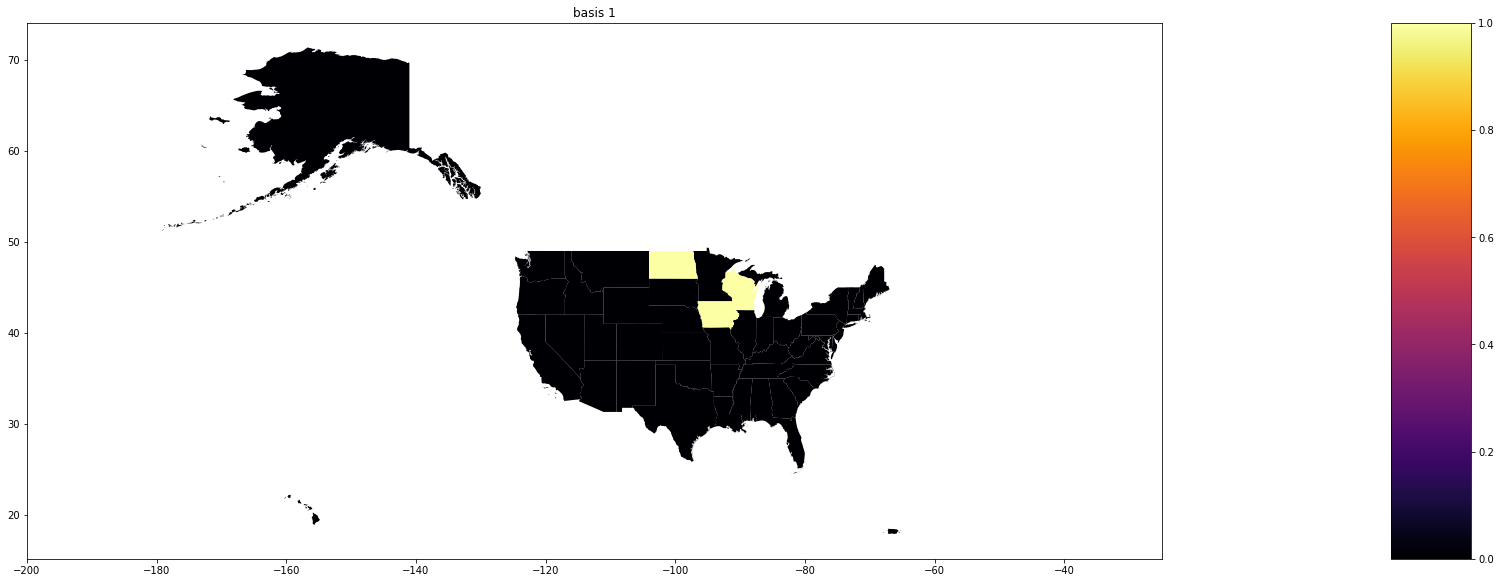

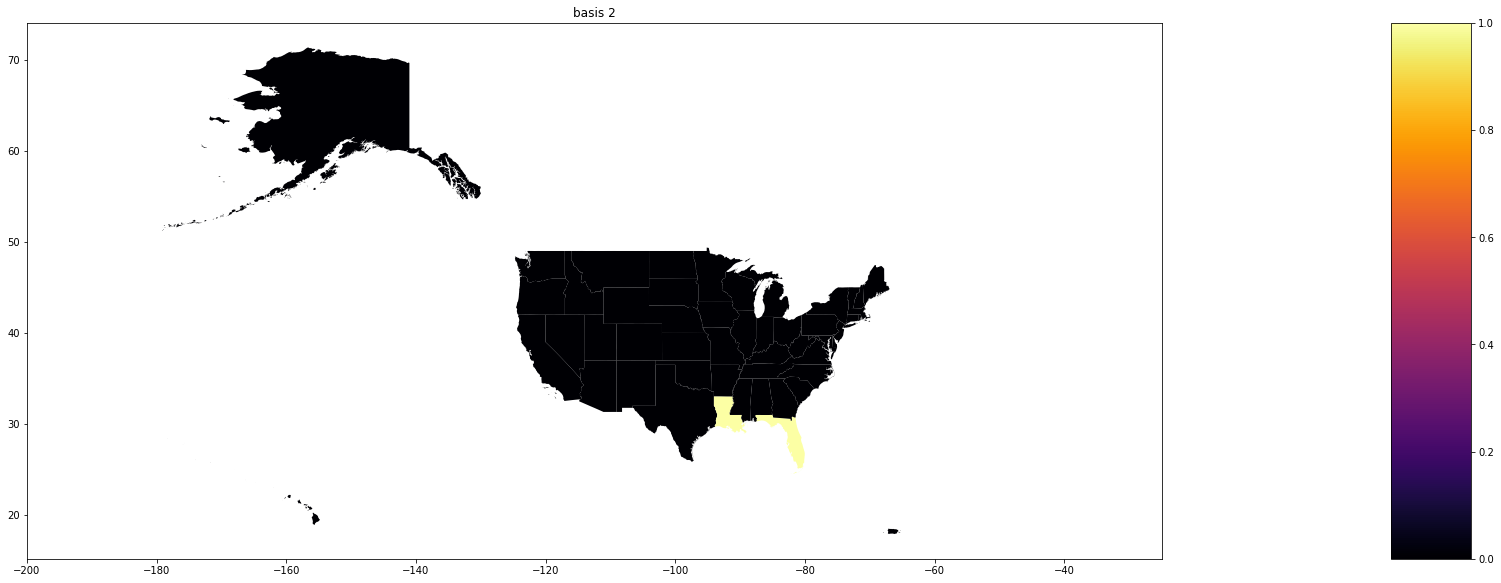

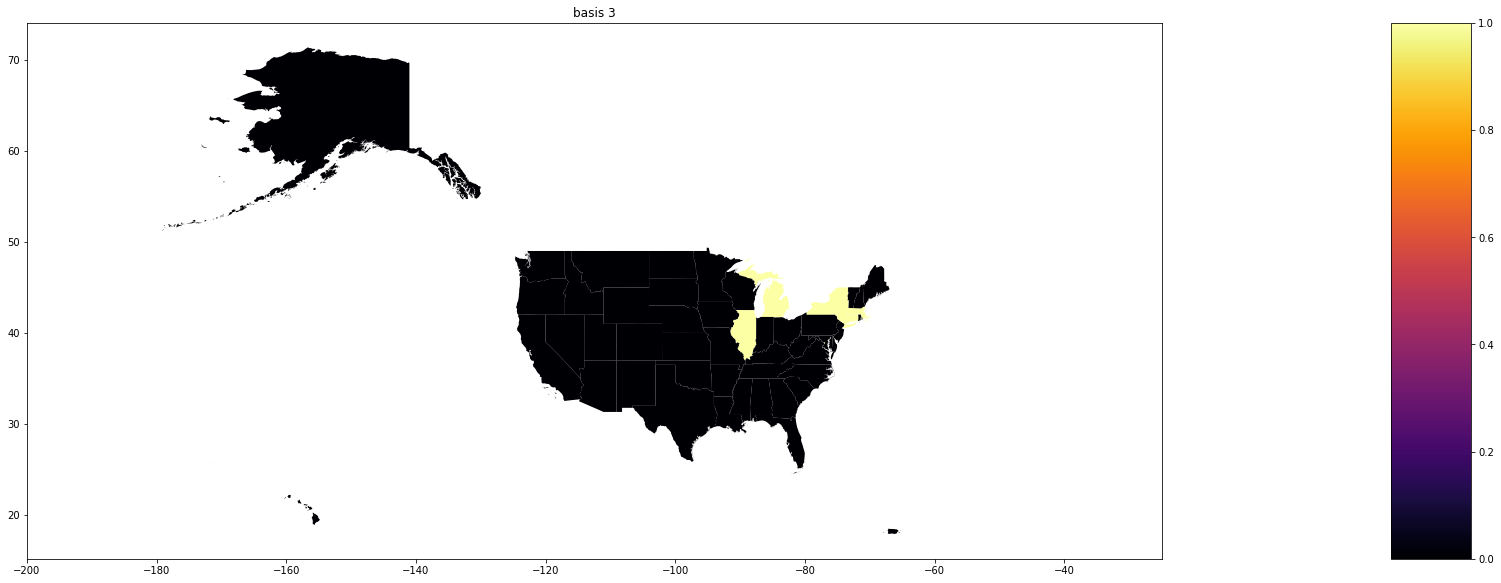

In [84]:
for row in ns.index:
    color_col = []
    for state in state_map.NAME:
        color_col.append(ns.loc[row,state])
    state_map['cluster'] = color_col 
    fig,ax = plt.subplots(1,1,figsize = (30,30))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%") 
    state_map.plot(column = "cluster", ax = ax,cax=cax, cmap = 'inferno', legend = True)
    ax.set_title(row)
    ax.set_xlim(-200,-25)

## G

In [89]:
# positions are state capitals
node_pos = {}
for node in state_caps.name:
    lat = state_caps.loc[state_caps.name == node].latitude
    long = state_caps.loc[state_caps.name == node].longitude
    node_pos[node] = (float(long), float(lat))

In [90]:
sources = []
dests = []
for col in gs.columns:
    sources.append(col)
    dests.append(col)
    for ind in gs.index:
        if gs.loc[ind, col] == 1:
            sources.append(col)
            dests.append(ind)
            
links_graph = pd.DataFrame([sources, dests]).T
links_graph.columns = ['source', 'dest']

In [87]:
Gl = nx.from_pandas_edgelist(links_graph, source = 'source', target = 'dest', edge_attr=None)

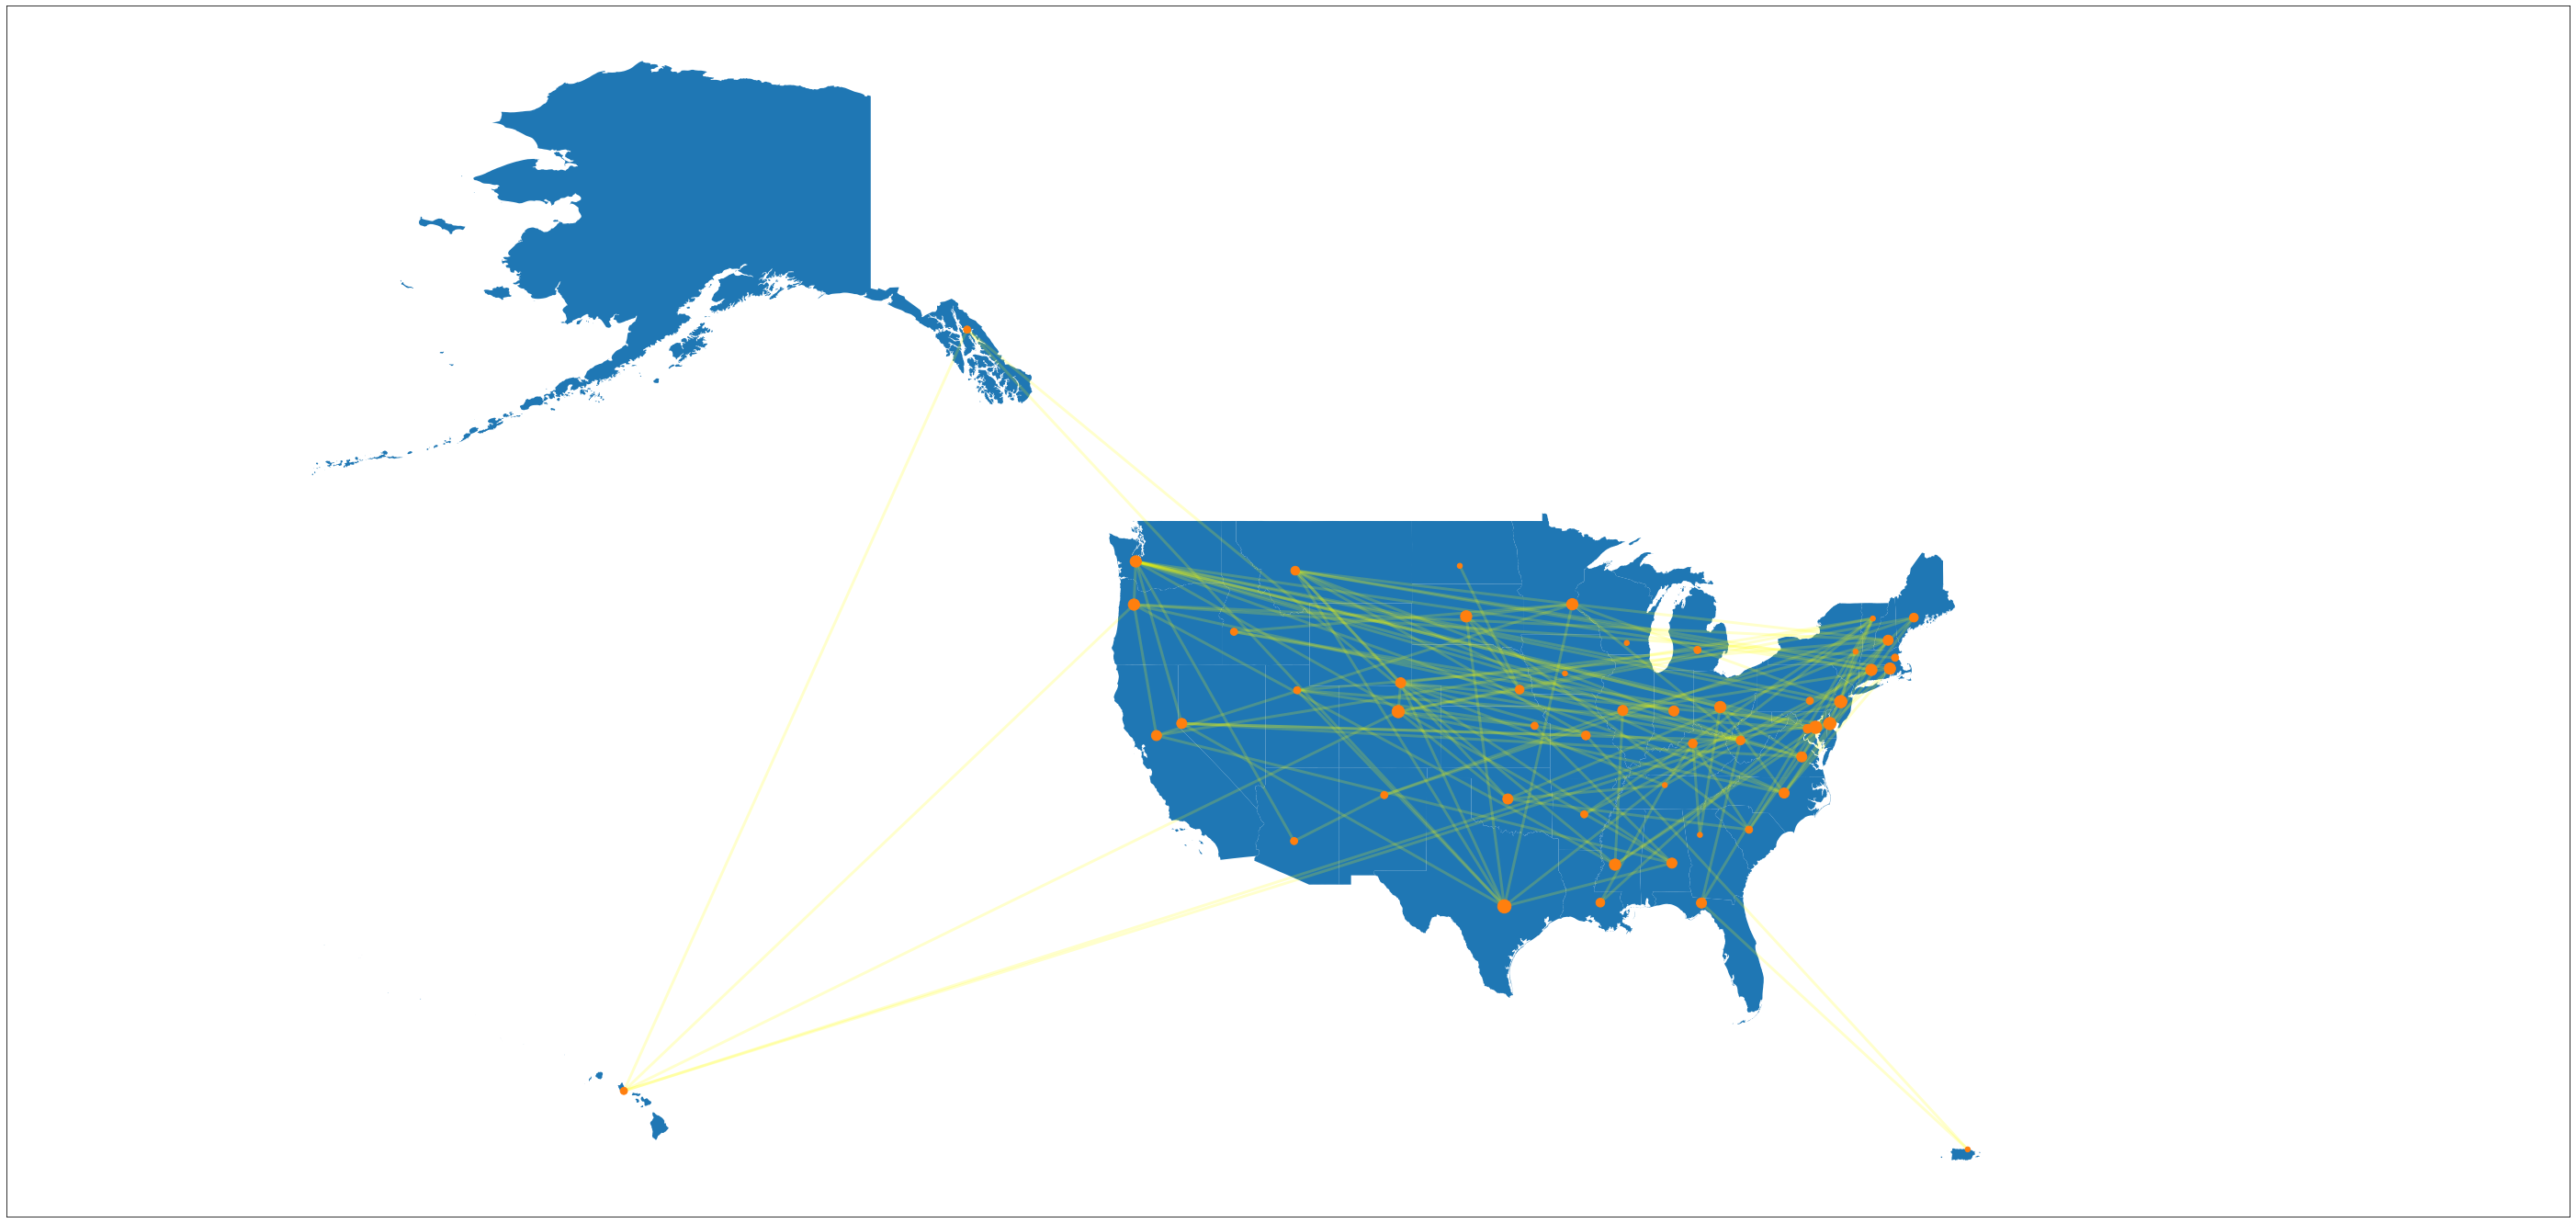

In [88]:
fig,ax = plt.subplots(1,1,figsize = (50,50))
state_map.plot(ax = ax)
ax.set_xlim(-200,-25)

nx.draw_networkx_nodes(Gl, pos = node_pos, ax = ax, nodelist = Gl.nodes(), node_color = 'tab:orange',
                      node_size = [len(links_graph.loc[links_graph.source == s])*30 for s in Gl.nodes()])
nx.draw_networkx_edges(Gl, pos = node_pos, edge_color='yellow',alpha=0.2, arrows = False, width = 3)

## With G initialized as adjacency graph

In [91]:
g0 = pd.DataFrame(columns = state_norm.dataframe.columns, index = state_norm.dataframe.columns)

In [92]:
# optional initialize an adjacency graph as input
for idx in state_adjy.index:
    row = state_adjy.loc[idx,:]
    g0.loc[row.adj, row.state] = 1
    
g0 = g0.replace(np.nan, 0)

In [93]:
links_g = applied_links_initiators(M, 5000,10, 0.9, 2, 9)
links_g.G0 = g0

In [94]:
gg,ng = links_g.find()

After burn in: 
                      Alabama  Alaska  Arizona  Arkansas  California  \
Alabama                     1       0        0         0           0   
Alaska                      0       1        0         0           0   
Arizona                     0       1        1         0           1   
Arkansas                    0       1        1         0           1   
California                  1       0        1         0           1   
Colorado                    0       0        1         0           0   
Connecticut                 1       1        0         0           1   
Delaware                    1       0        0         0           1   
District of Columbia        0       0        1         1           1   
Florida                     1       1        0         1           0   
Georgia                     1       0        0         1           0   
Hawaii                      0       0        1         0           0   
Idaho                       1       1        0  

In [95]:
gstate = gg[-1]
gstate.columns = state_norm.dataframe.columns
gstate.index = state_norm.dataframe.columns

In [96]:
nstate = n[-1]
nstate.columns = state_norm.dataframe.columns

### N

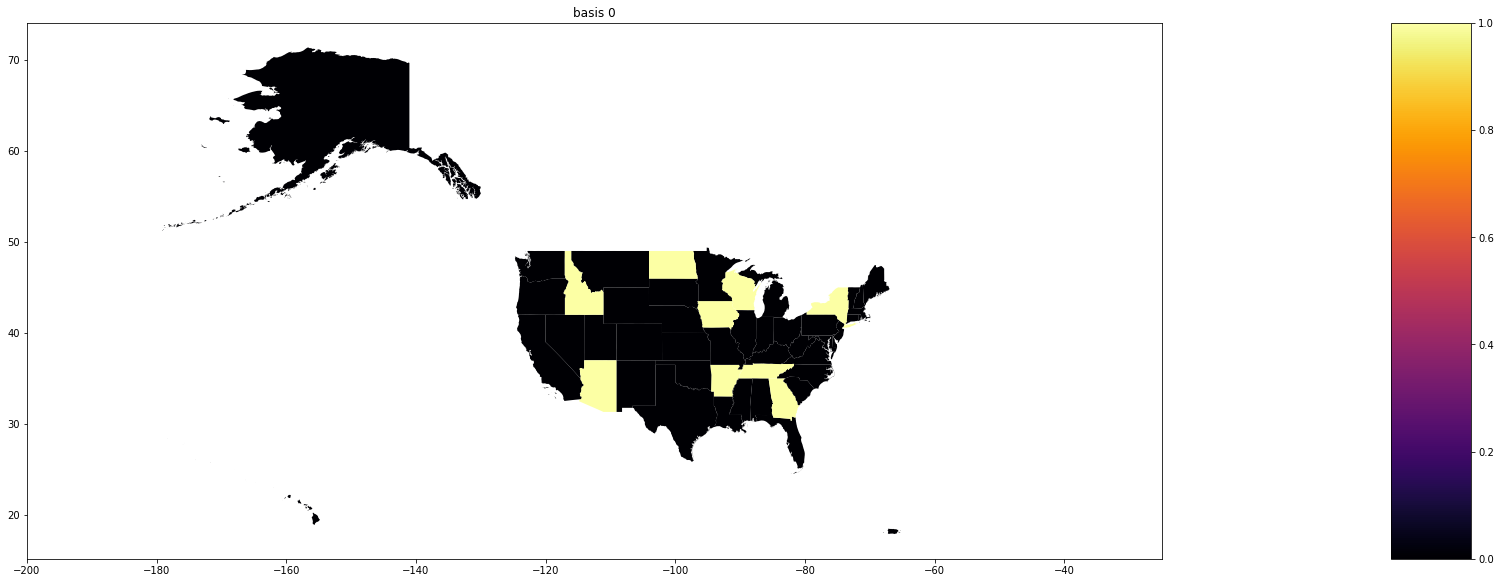

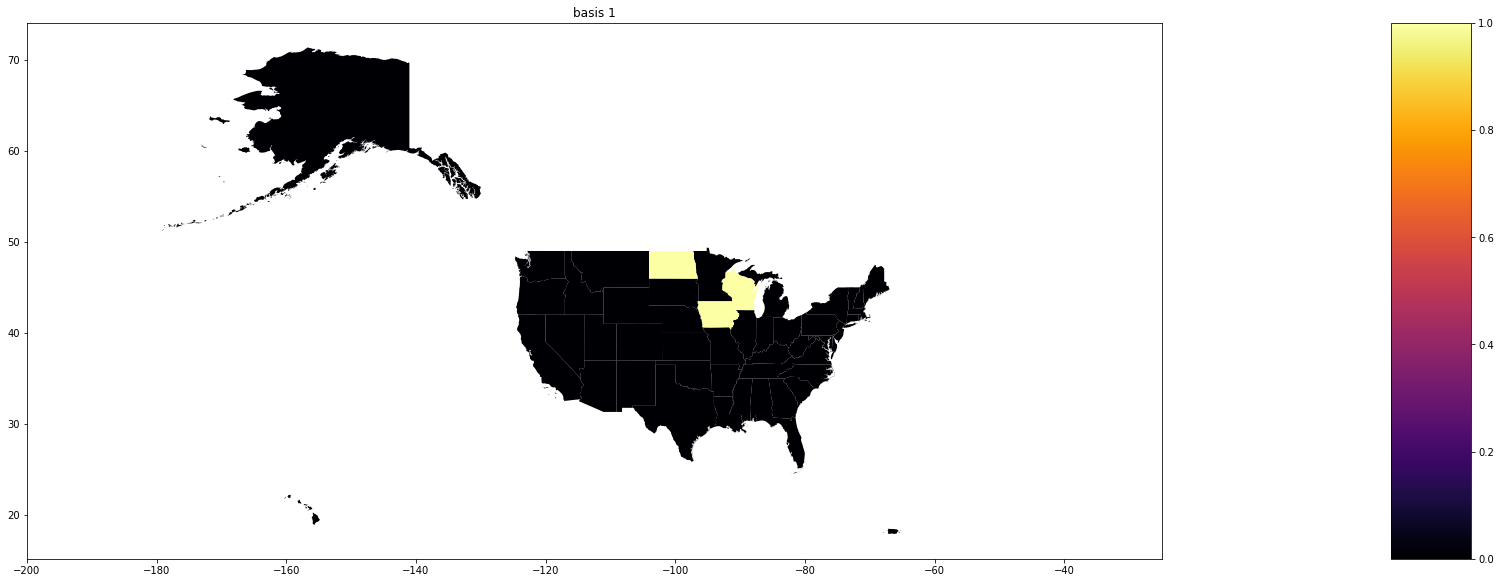

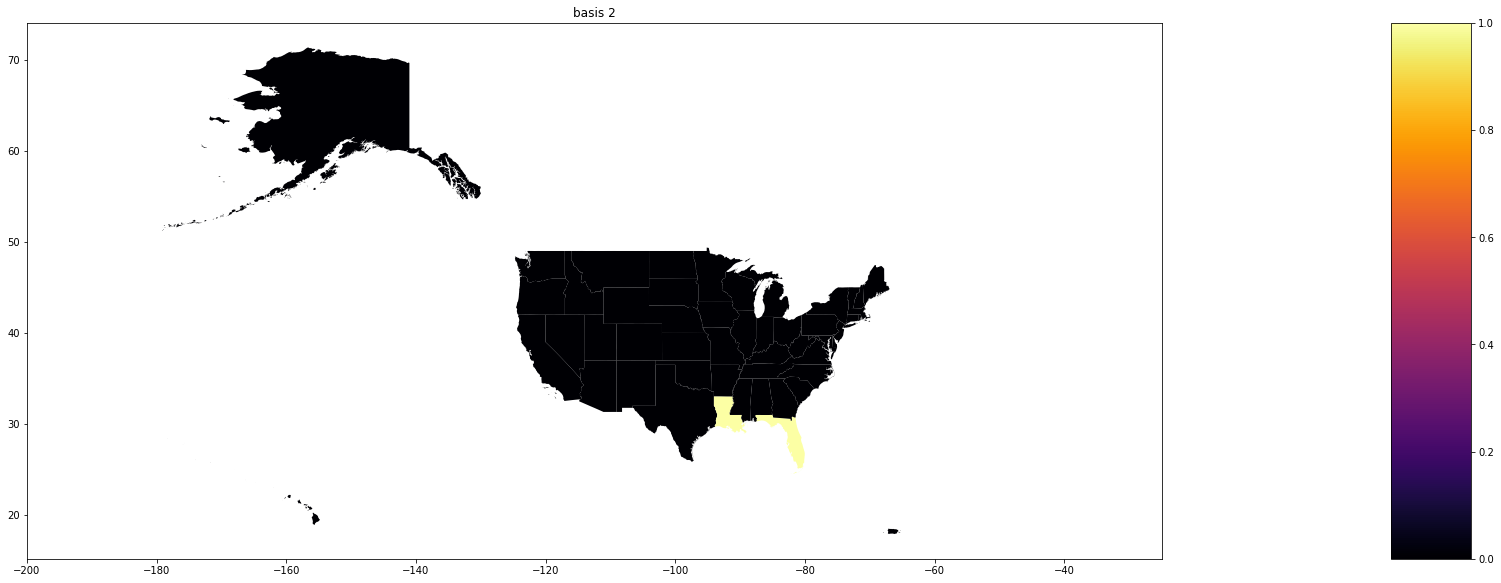

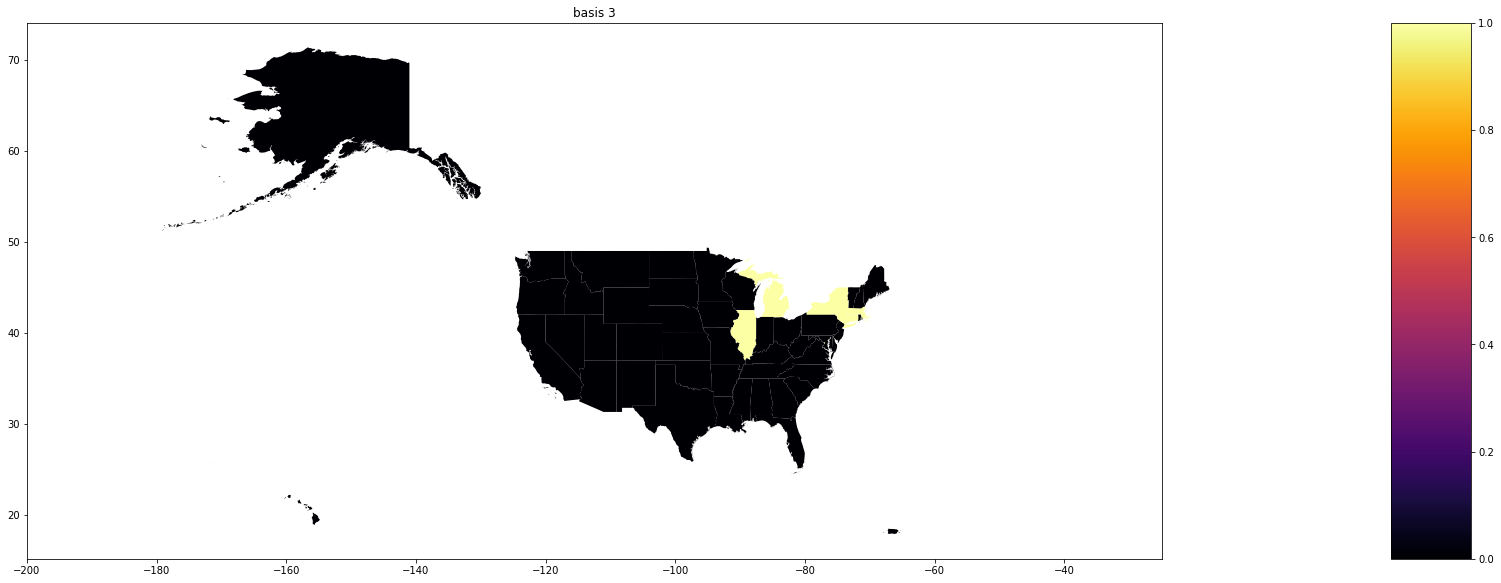

In [97]:
for row in nstate.index:
    color_col = []
    for state in state_map.NAME:
        color_col.append(nstate.loc[row,state])
    state_map['cluster'] = color_col 
    fig,ax = plt.subplots(1,1,figsize = (30,30))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%") 
    state_map.plot(column = "cluster", ax = ax,cax=cax, cmap = 'inferno', legend = True)
    ax.set_title(row)
    ax.set_xlim(-200,-25)

### G

In [98]:
sources = []
dests = []
for col in gstate.columns:
    sources.append(col)
    dests.append(col)
    for ind in gstate.index:
        if gstate.loc[ind, col] == 1:
            sources.append(col)
            dests.append(ind)
            
links_graph = pd.DataFrame([sources, dests]).T
links_graph.columns = ['source', 'dest']

In [99]:
Gl = nx.from_pandas_edgelist(links_graph, source = 'source', target = 'dest', edge_attr=None)

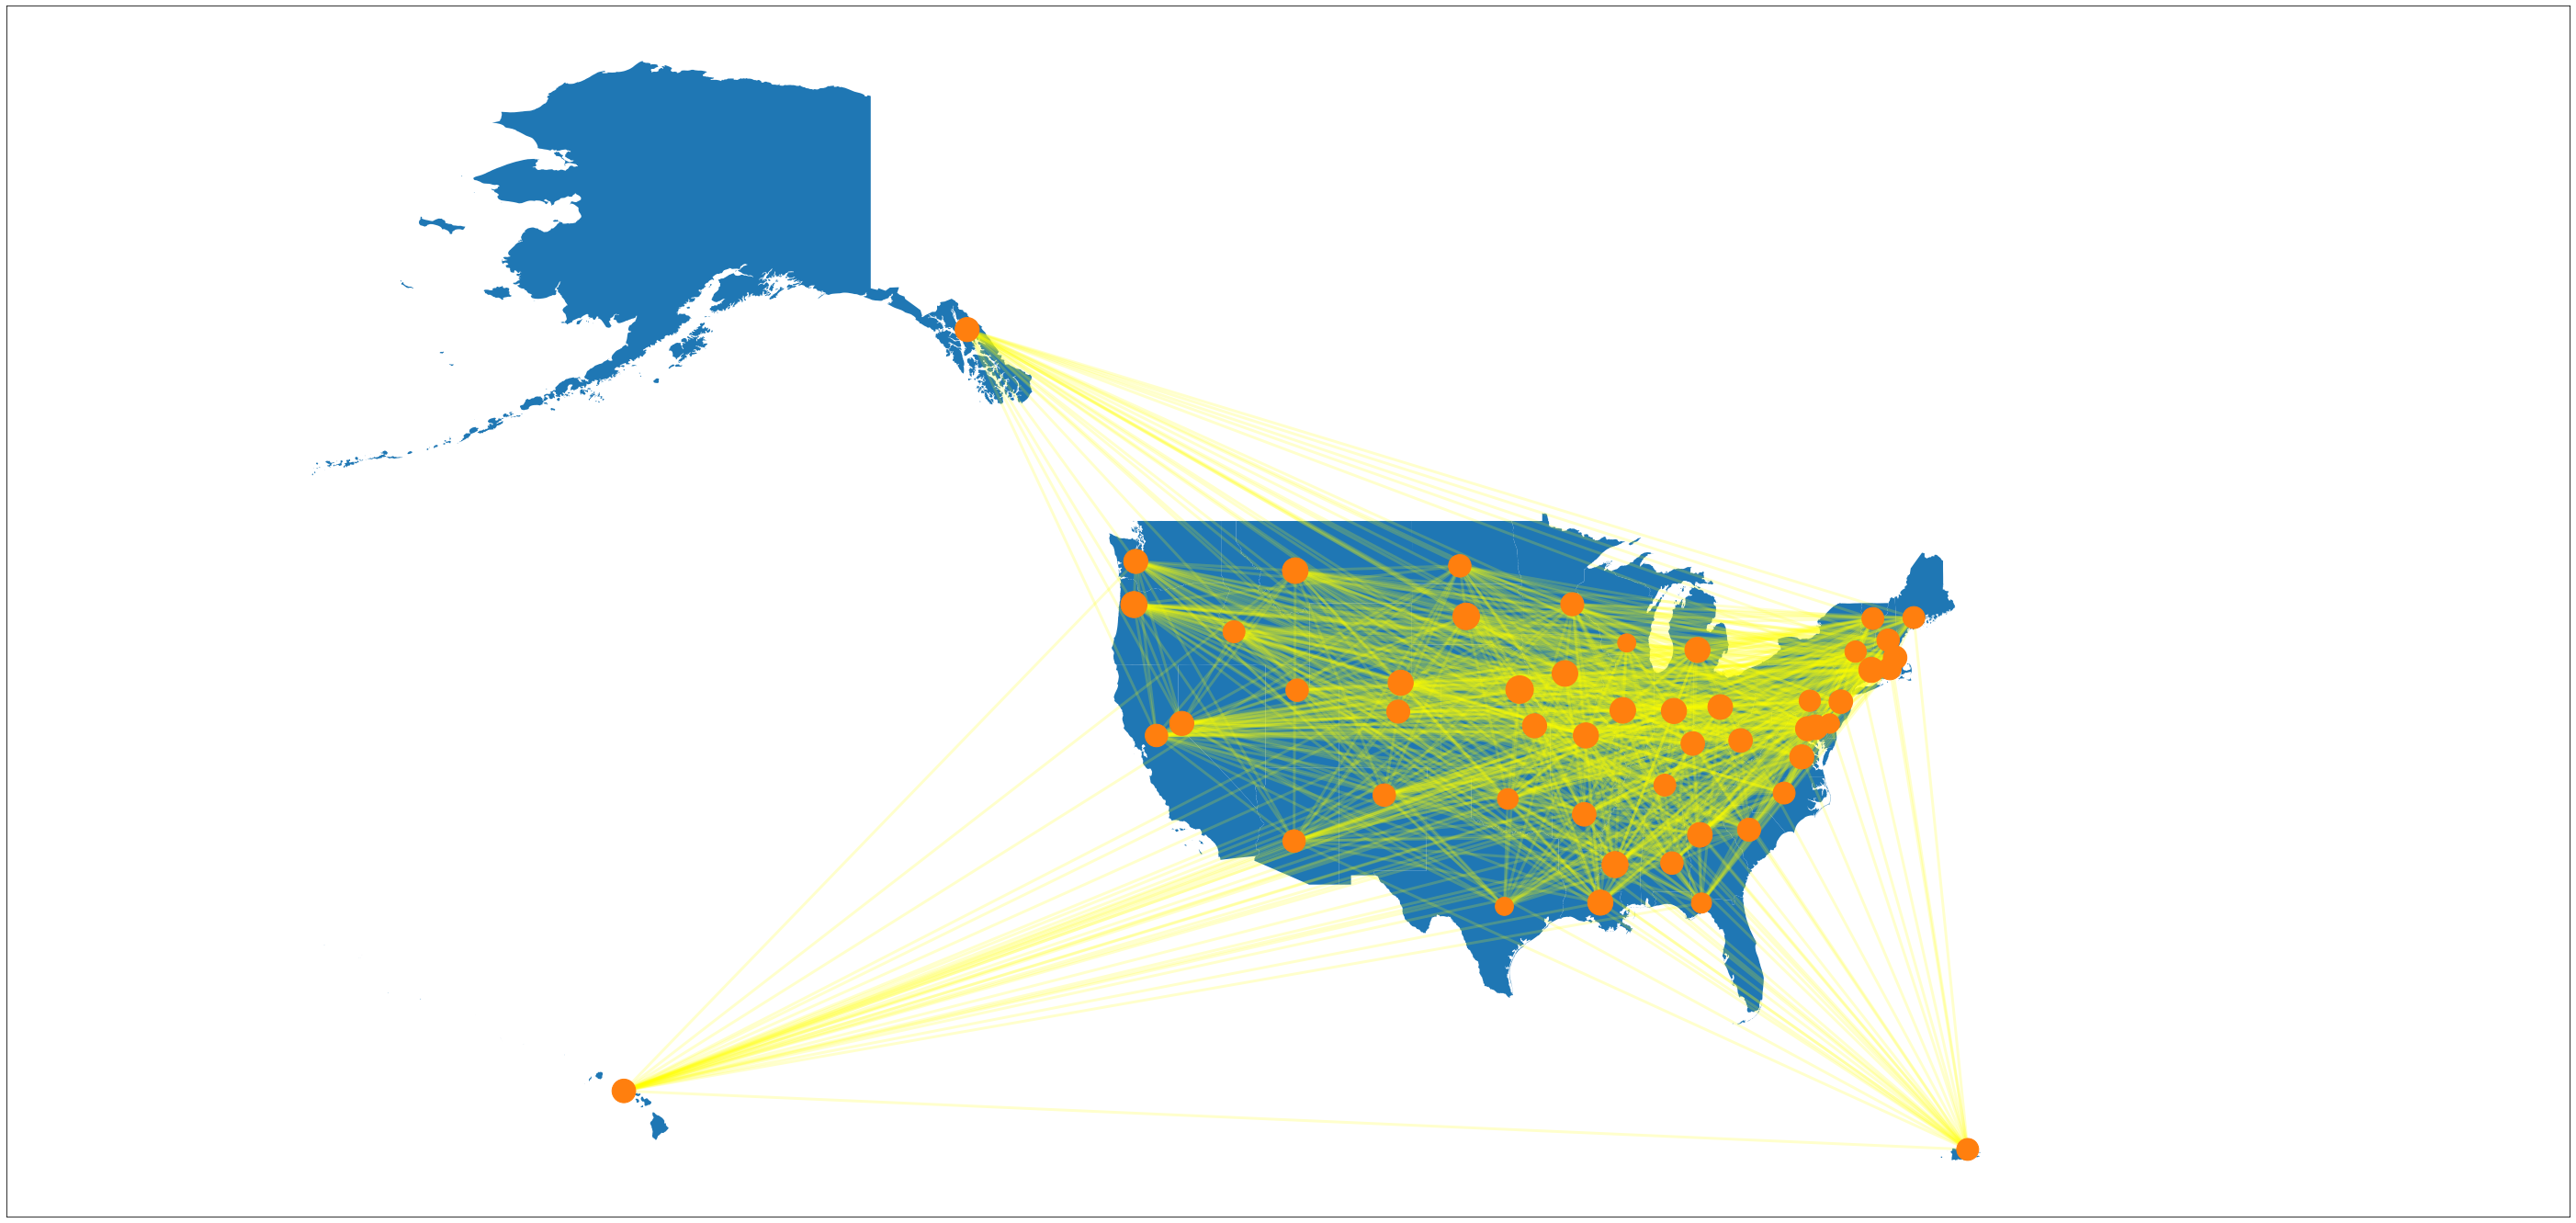

In [100]:
fig,ax = plt.subplots(1,1,figsize = (50,50))
state_map.plot(ax = ax)
ax.set_xlim(-200,-25)

nx.draw_networkx_nodes(Gl, pos = node_pos, ax = ax, nodelist = Gl.nodes(), node_color = 'tab:orange',
                      node_size = [len(links_graph.loc[links_graph.source == s])*30 for s in Gl.nodes()])
nx.draw_networkx_edges(Gl, pos = node_pos, edge_color='yellow',alpha=0.2, arrows = False, width = 3)

In [48]:
N0 = M.copy(deep = True)
for c in N0.columns:
    for i in N0.index:
        if N0.loc[i,c] <= M.mean().mean():
            N0.loc[i,c] = 0
        else:
            N0.loc[i,c] = 1

In [52]:
N0.equals(ns)

False

In [55]:
N0

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
basis 0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
basis 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
basis 2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
basis 3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
ns

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
basis 0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
basis 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
basis 2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
basis 3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
